# Project Goal

The goal in monocular depth estimation is to predict the depth value of each pixel or to infer general depth information, given only one single RGB image as input. In the example picture below, the leftmost column is RGB images, and the middle row is depth information maps of the corresponding images.Traditionally, depth information is obtained using specialized depth sensors such as LIDAR or structured light cameras. However, these sensors can be expensive, bulky, and have limited range. Monocular depth estimation provides a cost-effective and efficient way to obtain depth information using only a single camera, making it an attractive solution for many robotic applications.

As you may have experienced, this task isn’t so difficult for human eyes, but it still remains somewhat challenging for robots’ perception modules. It’s not hard to imagine the value depth estimation can bring: autonomous vehicles can be more aware of their distance to obstacles, factory robots can know better about the things they manipulate, etc. Roboticists in industry and academia care about this question a lot.


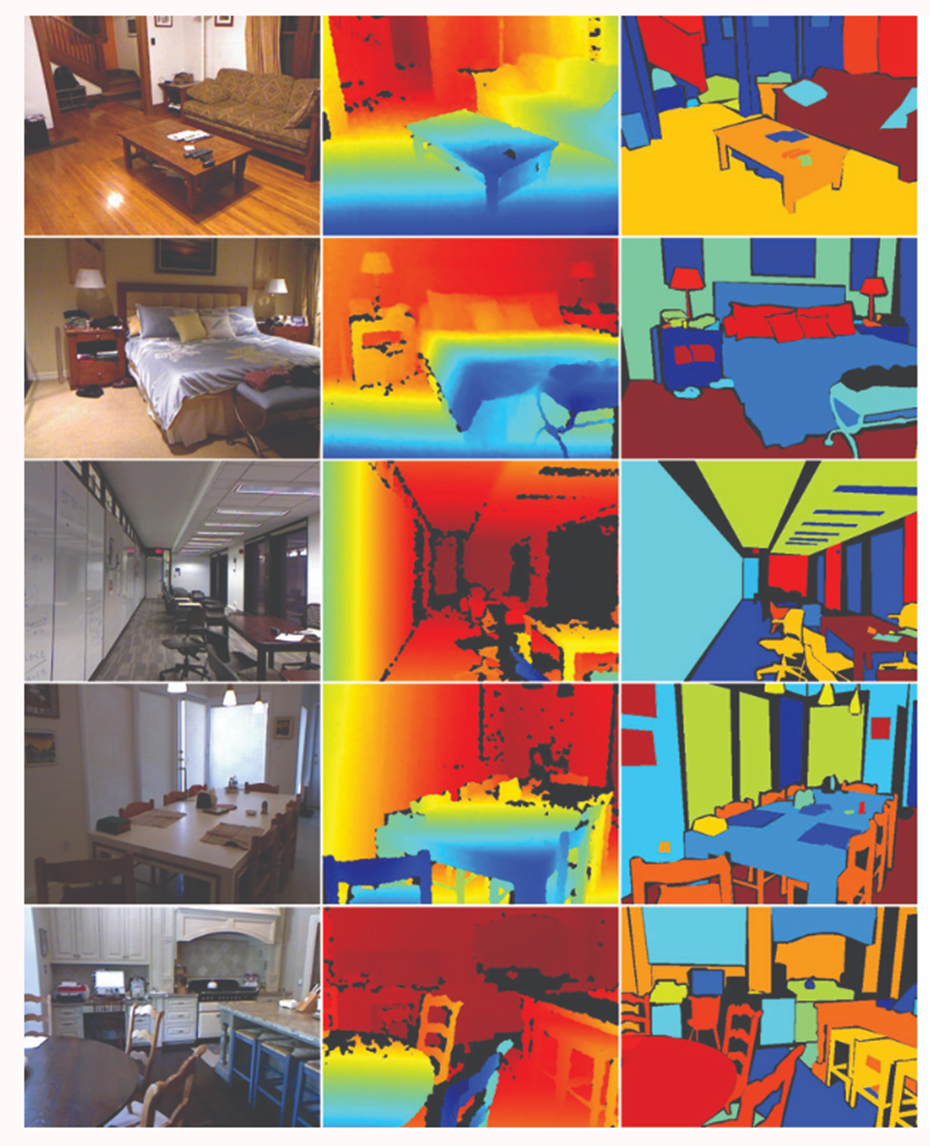

# Step 0: Introduction and Importing

First, we import the most fundamental packages/modules of PyTorch.

In [232]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
from torch.utils.data import random_split
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision.models import resnet18

Import some generic helper packages

In [233]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import cv2


Pytorch essentially does two things:
- Manipulates the so-called tensor data structure on GPU, just like NumPy can manipulate ndarray on CPU.
- Provides a automatic differentiation engine and some convenient helper functions for deep learning

Tensor is a data structure that can be thought of as a generalization of a matrix. A grayscale image is a matrix, but a colored image with 3 channels can be thought of a tensor.

Check if we are using GPU. Computation will be very slow if not.

In [234]:
torch.cuda.is_available()

True

The code sets a seed for the random number generators used by the random module, the numpy library, and the PyTorch library. By setting a seed, the code ensures that the results of the random number generation will be deterministic and reproducible, meaning that each time the code is run, the same sequence of random numbers will be generated. This is useful for debugging and testing, as well as for reproducing experimental results.


Finally, the code sets torch.backends.cudnn.deterministic to True. This flag controls the deterministic behavior of the cuDNN library, which is used by PyTorch for GPU acceleration. By setting this flag to True, the code ensures that the cuDNN library will produce deterministic results and further improves the reproducibility of the code.

In [235]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Step 1: Unsupervised Dataset analysis

We perform conduct unsupervised analysis on the NYU Depth V2 dataset for monocular depth estimation.

First, we set the path to the dataset directory data_path and then collects all the RGB and depth image file paths in the dataset using os.walk and endswith methods. The total number of RGB and depth images in the dataset are then printed.

Then, a sample RGB and depth image path is selected from the dataset for visualization purposes. The sample RGB image is loaded using cv2.imread, and its resolution and format are extracted from its shape and file path, respectively. Similarly, the sample depth image is loaded with cv2.imread using the cv2.IMREAD_ANYDEPTH flag for loading 16-bit depth images. Its resolution and format are also extracted from its shape and file path.

After this, the RGB and depth images are plotted side by side using matplotlib. The imshow method is used to display the images, and the set_title method is used to add titles to the subplots.

Overall, this code gives an idea about the number of images in the dataset, their resolutions and formats, and helps visualize a sample RGB and depth image.

In [236]:
data_path="../dataset/sync/"

# Get all image file paths in the dataset
rgb_image_paths = []
depth_image_paths = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.jpg'):
            rgb_image_paths.append(os.path.join(root, file))
        if file.endswith('.png'):
            depth_image_paths.append(os.path.join(root, file))

print(f'Total RGB images: {len(rgb_image_paths)}')
print(f'Total Depth images: {len(depth_image_paths)}')


Total RGB images: 36396
Total Depth images: 36396


In [237]:
# Choose a sample image from the dataset
sample_rgb_path = os.path.join(data_path, 'basement_0001a', 'rgb_00000.jpg')
sample_depth_path = os.path.join(data_path, 'basement_0001a', 'sync_depth_00000.png')

# Load the sample RGB image and get its resolution and format
rgb_image = cv2.imread(sample_rgb_path)
rgb_height, rgb_width, rgb_channels = rgb_image.shape
rgb_format = sample_rgb_path.split('.')[-1]

# Load the sample depth image and get its resolution and format
depth_image = cv2.imread(sample_depth_path, cv2.IMREAD_ANYDEPTH)
depth_height, depth_width = depth_image.shape
depth_format = sample_depth_path.split('.')[-1]


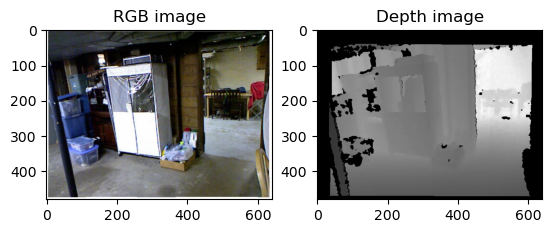

In [238]:
# Load the sample RGB image and get its resolution and format
rgb_image = cv2.imread(sample_rgb_path)
rgb_height, rgb_width, rgb_channels = rgb_image.shape
rgb_format = sample_rgb_path.split('.')[-1]

# Load the sample depth image and get its resolution and format
depth_image = cv2.imread(sample_depth_path, cv2.IMREAD_ANYDEPTH)
depth_height, depth_width = depth_image.shape
depth_format = sample_depth_path.split('.')[-1]

# Plot the RGB and depth images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB image')
axs[1].imshow(depth_image, cmap='gray')
axs[1].set_title('Depth image')
plt.show()

# Step 2. Dataloader

In [239]:
class MonocularDepthDataset(Dataset):
    def __init__(self, data_path, transforms_rgb=None, transforms_depth=None):
        self.data_path = data_path
        self.transforms_rgb = transforms_rgb
        self.transforms_depth = transforms_depth

        self.rgb_filenames = []
        self.depth_filenames = []
        for folder in sorted(glob.glob(os.path.join(data_path, "*"))):
            self.rgb_filenames.extend(sorted(glob.glob(os.path.join(folder, "rgb_*.jpg"))))
            self.depth_filenames.extend(sorted(glob.glob(os.path.join(folder, "sync_depth_*.png"))))
            
    def __getitem__(self, index):
        rgb = Image.open(self.rgb_filenames[index])
        depth = Image.open(self.depth_filenames[index])

        if self.transforms_rgb:
            rgb = self.transforms_rgb(rgb)

        if self.transforms_depth:
            # Convert depth image to float
            depth = np.array(depth).astype(np.float32)
            depth = Image.fromarray(depth)

            depth = self.transforms_depth(depth)

        return rgb, depth

    def __len__(self):
        return len(self.rgb_filenames)


### Normalization and Standardization

To put it simple:

***normalize***: making your data range in [0, 1]

**standardize**: making your data's mean=0 and std=1

In modern deep learning, sometimes it's often okay if you don't do these, but they will often help with faster training and better accuracy. Please see this [article](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn).

Calculate the mean and standard deviation of pixel values so we can standardize the dataset later

In [240]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# # Define the mean and standard deviation values for unnormalizing the RGB images
# mean_rgb = [0.485, 0.456, 0.406]
# std_rgb = [0.229, 0.224, 0.225]

# # Define the mean and standard deviation values for unnormalizing the depth images
# mean_depth = [0.5]
# std_depth = [0.5]

# Define the range for unnormalizing the RGB images
min_rgb = torch.tensor([0.0077, 0.0077, 0.0077])
max_rgb = torch.tensor([255., 255., 255.])

# Define the mean and standard deviation values for standardizing the RGB images
mean_rgb = torch.tensor([124.4099 / max_rgb[0], 106.5622 / max_rgb[1], 102.2792/ max_rgb[2]])
std_rgb = torch.tensor([67.5200/ max_rgb[0], 69.6597/ max_rgb[1], 72.1051/ max_rgb[2]])

# Define the range for unnormalizing the depth images
min_depth = torch.tensor([0.])
max_depth = torch.tensor([1.])

# Define the mean and standard deviation values for standardizing the depth images
mean_depth = torch.tensor([1896.3201 / 5780.2031])
std_depth = torch.tensor([1589.8859 / 5780.2031])

# mean_depth = [0.5]
# std_depth = [0.5]

# Define transformations for the RGB images
transform_rgb = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean_rgb, std = std_rgb)
])

# Define transformations for the depth images
transform_depth = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean_depth, std = std_depth),
])

# Create an instance of the dataset
depth_dataset = MonocularDepthDataset(data_path="../dataset/sync/", transforms_rgb=transform_rgb, transforms_depth=transform_depth)

In [241]:
# ! IMPORTANT- remove this after debugging
# ! Take 100 random images
# Create a list of indices
indices = list(range(len(depth_dataset)))

# Sample 100 random indices
random_indices = random.sample(indices, 100)

# Create a new dataset with the selected images
depth_dataset = [depth_dataset[i] for i in random_indices]

### Data Loading and Pre-processing

Leave out 10% of data from the training set as the validation set. **The model won't train on the validation set, but only do inference on it.** 

Validation set is similar to test set (hence the similar transformations), but it's a good practice to only run your model on test set for only **once**, and use your validation set as a gauge of how well your model generalize while tweaking hyper-parameters

In [242]:

# Determine the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each split
total_samples = len(depth_dataset)
train_samples = int(train_ratio * total_samples)
val_samples = int(val_ratio * total_samples)
test_samples = total_samples - train_samples - val_samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(depth_dataset, [train_samples, val_samples, test_samples])


In [243]:
print("Size of training set", len(train_dataset))
print("Size of validation set", len(val_dataset))
print("Size of test set", len(test_dataset))

Size of training set 80
Size of validation set 10
Size of test set 10


The final step is to create a DataLoader object. 

DataLoader object can be thought of as an iterator we use in Python. Deep learning dataset are usually too large to fit on memory (RAM, usually 8GB to 32GB) entirely, so we want to have a DataLoader that can spit out a fixed size of the dataset every time we need more data to process.

Batch_size can be thought of the number of data point we will ask the DataLoader to spit out. After DataLoader spit out a chunk partitioned from the entire dataset, we will send it to GPU's memory (VRAM) so GPU can work on it. Similarly, GPU has limited memory, usually ranging from a few GB to 40GB, so the number should be adjusted according to the VRAM of your GPU.

In [244]:
BATCH_SIZE = 32

# Create DataLoader objects for each split
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Test data loader and check for GPU

Additionally, the code sets the device to either the GPU (if available) or the CPU. The PyTorch library allows computations to be performed on either the GPU or the CPU, and the device to be used can be specified by setting the device variable.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


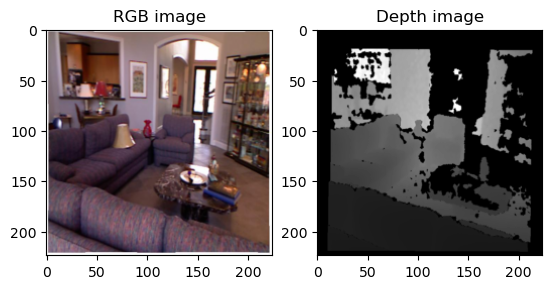

In [245]:

rgb, depth = next(iter(depth_dataset))

# Unnormalize the RGB image
unnormalize_rgb = transforms.Normalize(mean=[-mean_rgb[0]/std_rgb[0], -mean_rgb[1]/std_rgb[1], -mean_rgb[2]/std_rgb[2]],
                                        std=[1/std_rgb[0], 1/std_rgb[1], 1/std_rgb[2]])
rgb_unnormalized = unnormalize_rgb(rgb)

# Unnormalize the depth image
unnormalize_depth = transforms.Normalize(mean=[-mean_depth[0]/std_depth[0]], std=[1/std_depth[0]])
depth_unnormalized = unnormalize_depth(depth)

# Convert the tensor to a NumPy array and permute the dimensions to (height, width, 3) for the RGB image
rgb_array = rgb_unnormalized.permute(1, 2, 0).numpy()

# Convert the tensor to a NumPy array and reshape to (height, width) for the depth image
depth_array = depth_unnormalized.squeeze(0).numpy()

# Display the RGB and depth images
plt.subplot(1, 2, 1)
plt.imshow(rgb_array)
plt.title("RGB image")

plt.subplot(1, 2, 2)
plt.imshow(depth_array, cmap='gray')
plt.title("Depth image")

plt.show()

# Step 1: Model

The code provided defines a custom deep learning model called `DepthResNet` that builds on top of the pre-trained ResNet-18 architecture. The purpose of this model is to estimate depth maps from input RGB images.

Here's the thinking behind this implementation:

1. **Inheriting from `nn.Module`:** The `DepthResNet` class inherits from PyTorch's `nn.Module` class. This allows the custom model to use the features and functionalities of the base `nn.Module` class, which is the foundation of all PyTorch models.

2. **Loading and modifying the pre-trained ResNet-18 model:**
    - The model first loads a pre-trained ResNet-18 model using `resnet18(pretrained=True)`.
    - The original first convolutional layer is replaced with a new one (`self.resnet.conv1`) to accept 3-channel (RGB) images. This is done by setting the input channels to 3.

3. **Removing the classification head:**
    - The original fully connected layer (classification head) is removed from the ResNet-18 model, as it's not needed for depth estimation. This is achieved by slicing the children layers of the model and excluding the last two layers.

4. **Adding upsampling and convolutional layers:**
    - To generate a depth map with the same spatial dimensions as the input image, a series of upsampling layers (using `nn.Upsample` with bilinear interpolation) and convolutional layers are added.
    - The upsampling layers increase the spatial dimensions of the feature maps, while the convolutional layers (with 3x3 kernels and padding) process the features.

5. **Defining the forward pass:**
    - In the `forward` method, the input `x` is passed through the modified ResNet-18 model (without the classification head).
    - Then, `x` is upsampled and passed through the custom convolutional layers to generate the depth map.

The resulting `DepthResNet` model takes an input RGB image and outputs a depth map, which is a single-channel image with the same spatial dimensions as the input. The depth map contains the estimated depth values for each pixel in the input image.


In [246]:
class DepthResNet(nn.Module):
    def __init__(self):
        super(DepthResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        
        CONV_KERNEL_SIZE = 3 # * small is better, 5 or 3 is good enough
        CONV_PADDING = 1 # * no padding, pic gets smaller and smaller through the convolutional layers, apply padding to keep pic size constant

        # Load the pre-trained ResNet-18 model and modify its first convolutional layer to accept 
        # 3-channel (RGB) images
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove the fully connected layer (also called the classification head) from the original 
        # ResNet-18 model since we're going to replace it with our custom depth estimation layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Add upsampling and convolutional layers to generate a depth map with the same spatial dimensions 
        # as the input image. We use nn.Upsample with bilinear interpolation to upscale the feature maps 
        # and a series of convolutional layers with 3x3 kernels and padding to maintain spatial dimensions
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=CONV_KERNEL_SIZE, padding=CONV_PADDING)

    def forward(self, x):
        # Perform upsampling and pass the output through the custom convolutional layers to 
        # generate the depth map. The upsampling layers increase the spatial dimensions of the 
        # feature maps, while the convolutional layers process the features
        x = self.resnet(x)
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.upsample(x)
        x = self.conv5(x)
        
        return x

In [247]:
depth_model = DepthResNet()

# Check the model architecture
print(depth_model)

DepthResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# Step 2. Defining the optimizer and loss function

In [248]:
# Check if a GPU is available and use it if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [249]:
criterion = criterion.to(device)

For monocular depth estimation, the accuracy isn't calculated the same way as in classification tasks. You can use evaluation metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or other depth-specific metrics.

In [250]:
# ! RMSE
def calculate_accuracy(y_pred, y):
    mse = torch.pow(y_pred - y, 2).mean()
    rmse = torch.sqrt(mse)
    return rmse

# Step 3: Training the model

Set the model to training mode with model.train(). Some layers behave differently during training and testing.
For each iteration:

1. Acquire a batch of (rgb, depth) pairs from the data loader.
2. Send the acquired data to the GPU.
3. Clear the gradients calculated from the last iteration using `optimizer.zero_grad()`.
Pass the batch of RGB images through the model to obtain depth predictions.
1. Calculate the loss between the depth predictions and the actual depth values using the specified criterion.
2. Calculate the accuracy between the depth predictions and the actual depth values using the calculate_accuracy function.
3. Perform the backward pass to calculate gradients for each parameter (backpropagation).
4. Update the parameters by taking an optimizer step with `optimizer.step()`.
5. Accumulate the loss and accuracy values for the current epoch.
6. Finally, return the average epoch loss and accuracy by dividing the accumulated values by the number of iterations in the iterator.

The evaluation loop is similar to the training loop with a few differences:

1. We put our model into evaluation mode with `model.eval()` as some layers may have different behavior during training and testing (e.g., dropout, batch normalization).
2. We wrap the iterations inside a with `torch.no_grad()` context because, during evaluation, we no longer need to calculate gradients, which saves memory and computational time.
3. We do not need to update our optimizer because we are no longer optimizing our model.

Calculate both the average loss and the average accuracy of the model. 

This can be more informative as it provides an additional metric (accuracy) to assess the model's performance. 

In this case, the accuracy is calculated using the `calculate_accuracy` function, which computes the Root Mean Squared Error (RMSE) between the predicted depth map and the ground truth depth map.



In [251]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (rgb, depth) in iterator:
            # Move the data to the device
            rgb = rgb.to(device)
            depth = depth.to(device)

            depth_pred = model(rgb)

            loss = criterion(depth_pred, depth)

            accuracy = calculate_accuracy(depth_pred, depth)

            # * add .item() for both accuracy and loss to convert the values 
            # * from PyTorch tensors to Python numbers (scalars)
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

In [252]:
EPOCHS = 20

# Step 4: Evaluation on the validation set

In this case, "Average Validation Loss" and "Average Validation Accuracy" represent two different ways of evaluating your model's performance on the validation dataset:

Average Validation Loss: This is the average of the L2 loss (mean squared error) between the predicted depth maps and the ground truth depth maps. A lower value for the loss indicates that the model is performing better. However, it's not easy to interpret the loss value in isolation. We should compare it to the loss values of other models or baselines on the same dataset to get an idea of how well our model is performing.

Average Validation Accuracy: In this context, the term "accuracy" might be misleading, as it's not a classification accuracy. Instead, it represents the average RMSE (root mean squared error) between the predicted depth maps and the ground truth depth maps. A lower RMSE value indicates better performance. Like the loss, the RMSE value should be compared to the RMSE values of other models or baselines on the same dataset to understand your model's performance.

It's important to note that both the loss and the RMSE values are not bounded, so we cannot interpret them as percentages. When comparing your model's performance to others or baselines, make sure to use the same metric (loss or RMSE) for a fair comparison.

In [253]:
# best_model_filepath = './models/model_' + str(EPOCHS) + '.pt'
best_model_filepath = './models/model_18.pt'

test_model = DepthResNet()
test_model = torch.load(best_model_filepath, map_location=device)
test_model = test_model.to(device)

In [254]:
# Evaluate the model on the validation dataset
val_loss = evaluate(test_model, val_dataloader, criterion, device)
print(f"Average Validation loss: {val_loss[0]:.4f}")
print(f"Average Validation Accuracy: {val_loss[1]:.4f}")
# Validation loss: 14197389.0000

Average Validation loss: 5528986.0000
Average Validation Accuracy: 2351.3796


In [ ]:
rmse = evaluate_check(test_dataloader, test_model, device, root_mean_square_error)
abs_rel_diff = evaluate_check(test_dataloader, test_model, device, absolute_relative_difference)
thresh_check = evaluate_check(test_dataloader, test_model, device, lambda dp, d: threshold_check(dp, d, threshold=1.25))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


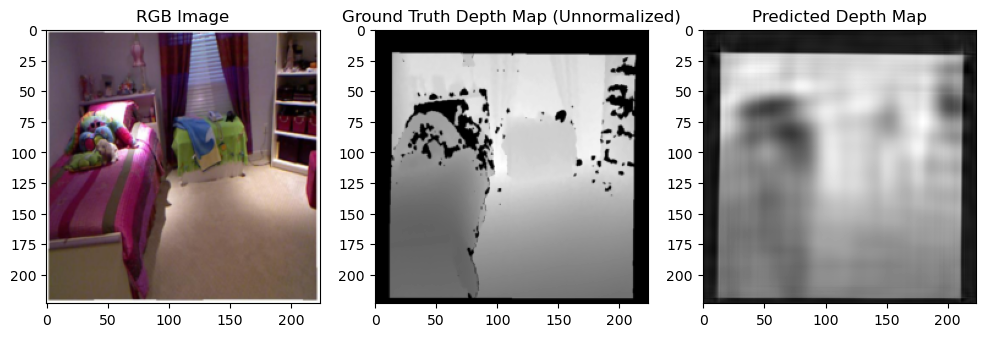

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


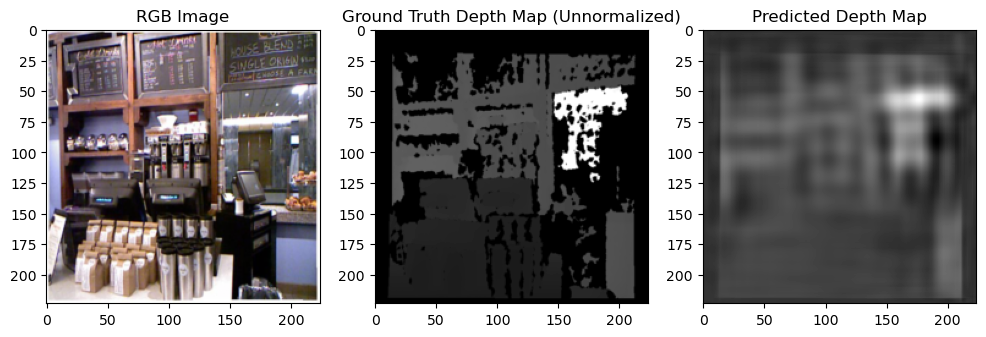

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


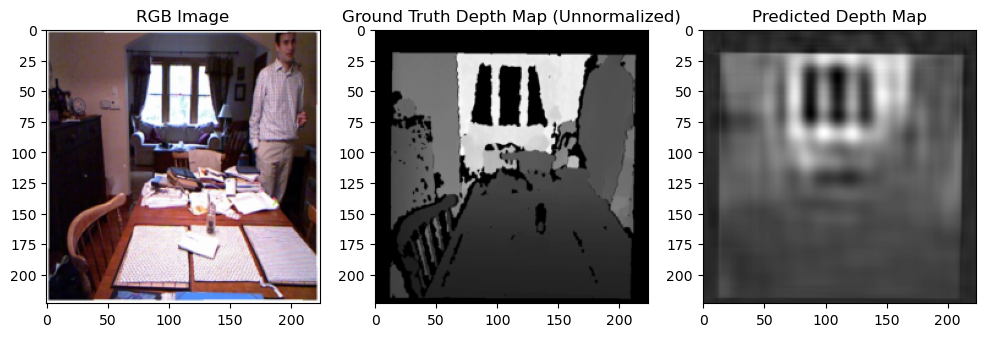

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


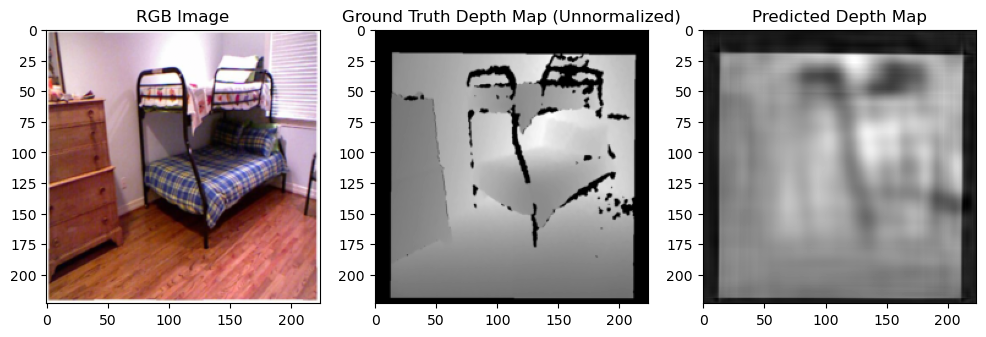

In [255]:


# Set the model to evaluation mode
test_model.eval()

# Get a batch of data from the validation dataset
rgb_batch, depth_batch = next(iter(val_dataloader))

# Move the batch to the device
rgb_batch = rgb_batch.to(device)

# Predict the depth maps
with torch.no_grad():
    predicted_depth_batch = test_model(rgb_batch)

# Move the predictions back to the CPU
predicted_depth_batch = predicted_depth_batch.cpu()

# Number of images to visualize
num_images = 4

# Define the unnormalize transform for the RGB images
unnormalize_rgb = transforms.Normalize(mean=[-mean_rgb[i]/std_rgb[i] for i in range(3)],
                                        std=[1/std_rgb[i] for i in range(3)])

# Define the unnormalize transform for the depth images
unnormalize_depth = transforms.Normalize(mean=[-mean_depth[i]/std_depth[i] for i in range(1)],
                                          std=[1/std_depth[i] for i in range(1)])

# Visualize the RGB images, ground truth depth maps, and predicted depth maps
for i in range(num_images):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Unnormalize the RGB image
    rgb_unnormalized = unnormalize_rgb(rgb_batch[i])

    # Unnormalize the depth image
    depth_unnormalized = unnormalize_depth(depth_batch[i])

    # Display the RGB image
    ax1.imshow(rgb_unnormalized.permute(1, 2, 0).cpu().numpy())
    ax1.set_title("RGB Image")

    # Display the unnormalized depth map
    ax2.imshow(depth_unnormalized.squeeze().cpu().numpy(), cmap="gray")
    ax2.set_title("Ground Truth Depth Map (Unnormalized)")

    # Display the predicted depth map
    ax3.imshow(predicted_depth_batch[i].squeeze().cpu().numpy(), cmap="gray")
    ax3.set_title("Predicted Depth Map")

    plt.show()

In [256]:
_, test_acc = evaluate(model=test_model, 
                        iterator=test_dataloader, 
                        criterion=criterion, 
                        device=device)

print('Our Average Test accuracy is:', test_acc)

Our Average Test accuracy is: 2236.223388671875


In abs rel, the error is relative to the magnitude of the ground truth itself. Basically, if the magnitude of the ground truth is large, then off by a small amount is no big deal.

In [257]:
def evaluate_check(dataloader, model, device, metric_fn):
    # Switch the model to evaluation mode
    model.eval()

    # Iterate over the test dataset
    with torch.no_grad():
        metric_sum = 0
        count = 0
        for rgb, depth in dataloader:
            # Move the data to the device
            rgb = rgb.to(device)
            depth = depth.to(device)

            # Get the predicted depth map
            depth_pred = model(rgb)

            # Calculate the metric for this image
            metric = metric_fn(depth_pred, depth)

            # Update the metric sum and count
            metric_sum += metric.item() * rgb.size(0)
            count += rgb.size(0)

    # Calculate the average metric for all images in the dataset
    avg_metric = metric_sum / count

    return avg_metric


In [258]:
def root_mean_square_error(depth_pred, depth):
    diff = torch.pow(depth - depth_pred, 2)
    
    numerator = torch.sum(diff)
    denominator = torch.numel(diff)
    return torch.pow(numerator / denominator, 0.5)


def absolute_relative_difference(depth_pred, depth):
    diff = torch.abs(depth - depth_pred) / depth
    diff = diff[~torch.isnan(diff)]  # Remove NaN values
    T = torch.numel(diff)
    return (1/T) * torch.sum(diff)


def threshold_check(depth_pred, depth, threshold=1.25):
    check = torch.max(depth / depth_pred, depth_pred / depth)
    numerator = torch.where(check < threshold, 1, 0).sum()
    denominator = check.numel()
    return (numerator / denominator) * 100


In [259]:
rmse = evaluate_check(test_dataloader, test_model, device, root_mean_square_error)
abs_rel_diff = evaluate_check(test_dataloader, test_model, device, absolute_relative_difference)
thresh_check = evaluate_check(test_dataloader, test_model, device, lambda dp, d: threshold_check(dp, d, threshold=1.25))

In [260]:
print(f"Root Means Squared on Test set: {rmse}")
print(f"Absolute Relative Difference on Test set: {abs_rel_diff}")
print(f"Threshold check on Test set: {thresh_check:.2f}%")

Root Means Squared on Test set: 2236.223388671875
Absolute Relative Difference on Test set: -241.43280029296875
Threshold check on Test set: 74.22%
